In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy estimation (TRAINING)

**Author(s):** Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Recommended datasample(s):** ``gamma1`` (dataset used to build the energy model)

**Data level(s):** DL1b (telescope-wise image parameters) + DL2 (only shower geometry)

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding information from training data used for the training of the energy model.

**Requirements:**

To run this notebook you will need a set of TRAINING data produced with ``protopipe-TRAINING``.

To get a filled notebook and reproduce these results,

- get the necessary input files (see documentation)
- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_DL2_to_energy-estimation``

To obtain the list of all available parameters add ``--help-notebook``.

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

**TODO:**  

- ...

## Table of contents
- [Charge profiles](#Charge-profiles)
- [Correlation between some parameters in bins of true energy](#Correlation-between-some-parameters-in-bins-of-true-energy)

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, PowerNorm
count = 0
cmap = dict()
for key in colors.cnames:
    if 'dark' in key:
    #if key in key:
        cmap[count] = key
        count = count + 1
#cmap = {'black': 0, 'red': 1, 'blue': 2, 'green': 3}
cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tables
import seaborn as sns

from protopipe.pipeline.utils import load_config
from protopipe.pipeline.io import get_camera_names, read_protopipe_TRAINING_per_tel_type

## Functions

In [3]:
def plot_profile(ax, data, xcol, ycol, n_xbin, x_range, logx=False, **kwargs):
    color = kwargs.get('color', 'red')
    label = kwargs.get('label', '')
    fill = kwargs.get('fill', False)
    alpha = kwargs.get('alpha', 1)
    xlabel = kwargs.get('xlabel', '')
    ylabel = kwargs.get('ylabel', '')
    xlim = kwargs.get('xlim', None)
    ms = kwargs.get('ms', 8)
    
    if logx is False:
        bin_edges = np.linspace(x_range[0], x_range[-1], n_xbin, True)
        bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
    else:
        bin_edges = np.logspace(np.log10(x_range[0]), np.log10(x_range[-1]), n_xbin, True)
        bin_center = np.sqrt(bin_edges[1:] * bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
    
    y = []
    yerr = []
    for idx in range(len(bin_center)):
        counts = data[ (data[xcol] > bin_edges[idx]) & (data[xcol] <= bin_edges[idx+1]) ][ycol]
        y.append(counts.mean())
        yerr.append(counts.std() / np.sqrt(len(counts)))
        
    ax.errorbar(x=bin_center, y=y, xerr=bin_width / 2., yerr=yerr, label=label, fmt='o', color=color, ms=ms)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx is True:
        ax.set_xscale('log')
    ax.legend(loc='upper right', framealpha=1, fontsize='medium')
    #ax.grid(which='both')
    return ax

## Input data

In [4]:
# Parametrized cell
# Modify these variables according to your local setup outside of the container
analyses_directory = None  # path to the 'analyses' analyses folder
output_directory = Path.cwd() # default output directory for plots
analysis_name = None # Name of the analysis stored in 'analyses_folder'
input_filename = None # Name of the file produced with protopipe
model_configuration_filename = "RandomForestRegressor.yaml" # Name of the configuration file for the energy model
images_condition = None # Quality cuts as a pandas query (e.g. 'good_image == 1 and is_valid == True and hillas_intensity > 0')
selected_parameters = ['hillas_width','concentration_pixel'] # List of selected parameters to plot from the file
eval_parameters = {'log10_intensity': 'log10(hillas_intensity)', 'log10_impact_dist': 'log10(impact_dist)'} # Additional DERIVED parameters to plot (dictionary of keys and pandas eval expressions)
select_from_model = True # If True read quality cuts and plot selected parameters from model configuration

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
analysis_name_2 = ""
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_simtel_file = "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz"
input_filenames = {
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
select_from_model = "False"
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/TRAINING"


In [6]:
# Convert boolean string values to actual booleans
if select_from_model == "False":
    select_from_model = False

In [7]:
# Read configuration file for energy regression model
# This is useful for understanding if the parameters you want to use as features for the model are correlated
model_configuration_path = Path(analyses_directory) / analysis_name / "configs" / model_configuration_filename
model_configuration = load_config(model_configuration_path)

# Read feature list from model configutation file
features_basic = model_configuration["FeatureList"]["Basic"]
features_derived = model_configuration["FeatureList"]["Derived"]
features = features_basic + list(features_derived)

In [8]:
input_directory = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_energy_estimation")

if not input_filename:
    try:
        input_filename = input_filenames["TRAINING_energy_gamma"]
    except (NameError, KeyError):
        input_filename = "TRAINING_energy_tail_gamma_merged.h5"

cameras = get_camera_names(input_directory, input_filename)      
data = read_protopipe_TRAINING_per_tel_type(input_directory, input_filename, cameras)

for camera in cameras:
    
    print(f"Number of images for {camera} = {len(data[camera])}")
    
    # select data
    if images_condition:
        data[camera] = data[camera].query(images_condition)
    elif (not images_condition) and select_from_model:
        images_condition = ' and '.join(model_configuration["SigFiducialCuts"])
    else:
        pass  
    
    print(f"Number of SELECTED images for {camera} = {len(data[camera])}")

Number of images for LSTCam = 2158224
Number of SELECTED images for LSTCam = 2158224
Number of images for NectarCam = 2382502
Number of SELECTED images for NectarCam = 2382502


In [9]:
# Compute derived features and add them to the dataframe
for camera in cameras:
    if select_from_model:
        for key, expression in features_derived.items():
            data[camera].eval(f'{key} = {expression}', inplace=True)
    else:
        for key, expression in eval_parameters.items():
            data[camera].eval(f'{key} = {expression}', inplace=True)

In [10]:
true_energy_bin_edges = np.logspace(np.log10(0.02), np.log10(200), num=4)

In [11]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

## Charge profiles
[back to top](#Table-of-contents)

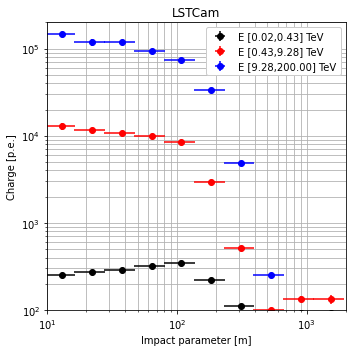

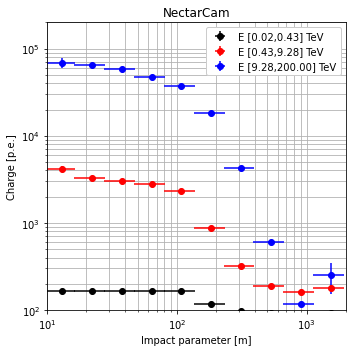

In [12]:
energy_range = true_energy_bin_edges

for camera in cameras:

    fig = plt.figure(figsize=(5,5))
    plt.title(camera)
    ax = plt.gca()
    for jdx in range(0, len(energy_range) - 1):

        data_sel = data[camera][(data[camera]['true_energy'] >= true_energy_bin_edges[jdx]) & 
                            (data[camera]['true_energy'] < true_energy_bin_edges[jdx + 1])]

        xbins = 10 + 1
        xrange = [10, 2000]
        opt = {'xlabel': 'Impact parameter [m]', 'ylabel': 'Charge [p.e.]', 'color': cmap[jdx],
               'label': 'E [{:.2f},{:.2f}] TeV'.format(true_energy_bin_edges[jdx], true_energy_bin_edges[jdx+1]),
               'ms': 6}
        plot_profile(ax, data=data_sel,
                     xcol='impact_dist', ycol='hillas_intensity',
                     n_xbin=xbins, x_range=xrange, logx=True, **opt)

        ax.set_yscale('log')
        ax.set_yscale('log')
        ax.set_ylim([100, 2. * 100000.])
        ax.set_xlim([10, 2000])

    ax.grid(which='both')
    plt.tight_layout()

    fig.savefig(plots_folder / f"charge_profile_protopipe_{camera}_{analysis_name}.png")

## Correlation between some parameters in bins of true energy
[back to top](#Table-of-contents)

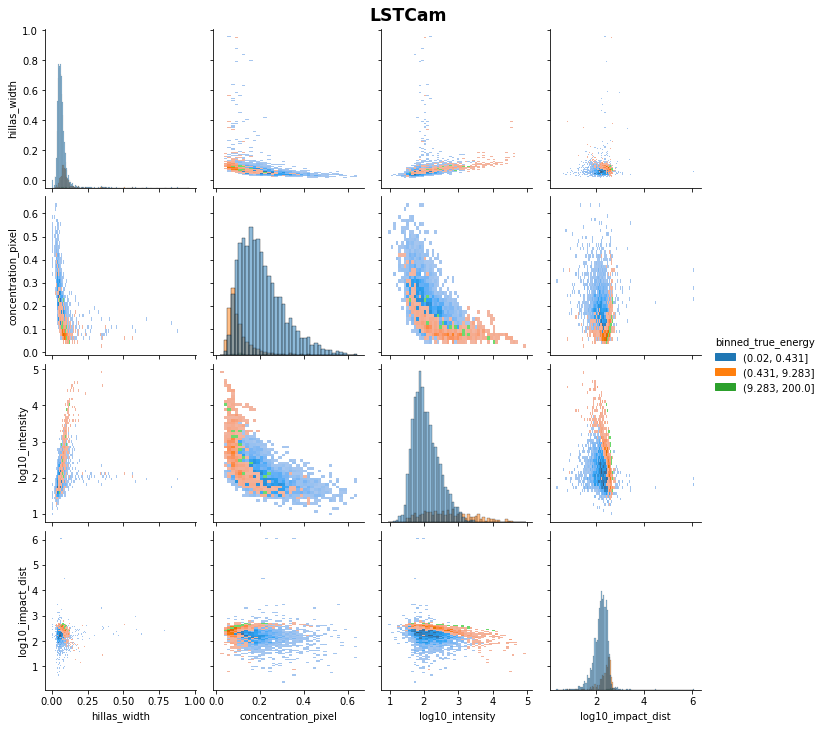

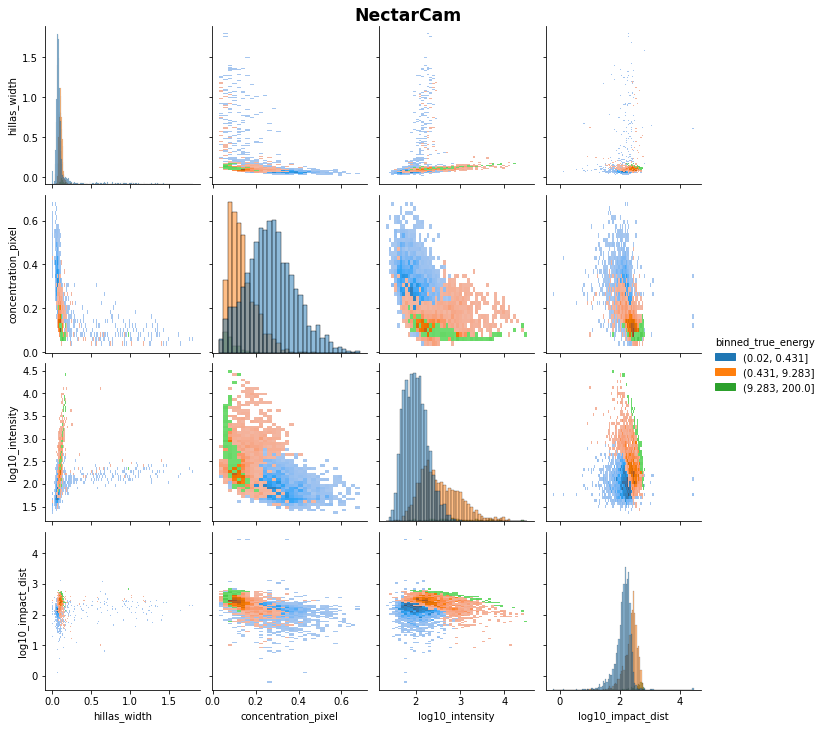

In [13]:
if select_from_model:
    parameters_to_plot = features
else:
    parameters_to_plot = selected_parameters + list(eval_parameters)

for i, camera in enumerate(cameras):

    #plt.figure()

    data[camera]["binned_true_energy"] = pd.cut(data[camera]["true_energy"], bins=true_energy_bin_edges)
    grouped_by_true_energy = data[camera].groupby(['binned_true_energy'])

    pairplot = sns.pairplot(data[camera][:5000],
                 vars=parameters_to_plot,
                 kind="hist",
                 hue="binned_true_energy")
    
    pairplot.fig.suptitle(camera, y=1.01, size="xx-large", weight="bold")
    None